In [105]:
# Import ML libraries
import pycaret
import xgboost

# Snowpark for Python
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T
import snowflake.snowpark.functions as F
import snowflake.snowpark as snowpark
from snowflake.snowpark.functions import datediff, to_date, col, expr

# Import Misc
import json
import pandas as pd
# from pycaret.classification import setup, compare_models


In [106]:
# Create Snowflake Session object
connection_parameters = json.load(open("connection.json"))
session = Session.builder.configs(connection_parameters).create()

In [107]:
# Connecting to the correct table
tableName = 'PURCHASE_ORDER_HISTORY'
dataframe = session.table(tableName)

# Calculation to find the lag between Planned Delivery from Actual Delivery
dataframe = dataframe.withColumn("target_feature",
                                    datediff('day', 
                                            col("DELIVERY_DATE_ML"), 
                                            col("FIRST_GR_POSTING_DATE_ML")))


# Example: Selecting specific columns
# This selects only a subset of columns. Adjust the column names as needed.
filtered_dataframe = dataframe.select(
    col("PURCHASE_DOCUMENT_ITEM_ID"), # ID for purchase order
    col("CREATE_DATE"),            # day purchase order was created
    col("COMPANY_CODE_ID"),           # copmany w/in INVISTA making purchase
    col("VENDOR_ID"),                 # ID of the vendor "we" are purchasing from
    col("POSTAL_CD"),                 # postal code associated w company code ID
    col("MATERIAL_ID"),               # ID of material being purchase
    col("SUB_COMMODITY_DESC"),        # description of sub commodity
    col("MRP_TYPE_ID"),               # determined if material is reordered manually or automatically
    col("PLANT_ID"),                  # ID of plant making purchase
    col("REQUESTED_DELIVERY_DATE"),# delivery date from requisition
    col("INBOUND_DELIVERY_ID"),       # ID for delivery
    col("INBOUND_DELIVERY_ITEM_ID"),  # ID of item w/in delivery
    col("PLANNED_DELIVERY_DAYS"),     # Amount of days expected to take
    col("FIRST_GR_POSTING_DATE"),  # expected delivery date        
    col("target_feature")             # Lag between Planned Delivery from Actual Delivery 
)


# Print a sample of the filtered dataframe to standard output.
filtered_dataframe.show()

# Optionally, you might want to filter rows based on some conditions
# Example: Filtering out rows where FIRST_GR_POSTING_DATE_ML is NULL
filtered_dataframe = filtered_dataframe.filter(col("FIRST_GR_POSTING_DATE").is_not_null())

# filtered_dataframe = filtered_dataframe[filtered_dataframe['PLANNED_DELIVERY_DAYS'] < 6]

# Show the DataFrame after filtering
filtered_dataframe.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"PURCHASE_DOCUMENT_ITEM_ID"  |"CREATE_DATE"  |"COMPANY_CODE_ID"  |"VENDOR_ID"  |"POSTAL_CD"  |"MATERIAL_ID"  |"SUB_COMMODITY_DESC"                    |"MRP_TYPE_ID"  |"PLANT_ID"  |"REQUESTED_DELIVERY_DATE"  |"INBOUND_DELIVERY_ID"  |"INBOUND_DELIVERY_ITEM_ID"  |"PLANNED_DELIVERY_DAYS"  |"FIRST_GR_POSTING_DATE"  |"TARGET_FEATURE"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [108]:
# Assuming 'filtered_dataframe' is the DataFrame you've prepared in Snowflake
# Convert the Snowpark DataFrame to a Pandas DataFrame with consideration for NULL values

# Convert DataFrame to Pandas, handling NULL values by allowing float conversion
df = filtered_dataframe.fillna(0).to_pandas()  # This replaces NULL with 0 before conversion

Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "COMPANY_CODE_ID", Type: StringType(16777216), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "VENDOR_ID", Type: StringType(16777216), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "POSTAL_CD", Type: StringType(16777216), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "SUB_COMMODITY_DESC", Type: StringType(16777216), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "PLANNED_DELIVERY_DAYS", Type: StringType(16777216), Input Value: 0, Type: <class 'int'>


In [109]:
df.head()

,PURCHASE_DOCUMENT_ITEM_ID,CREATE_DATE,COMPANY_CODE_ID,VENDOR_ID,POSTAL_CD,MATERIAL_ID,SUB_COMMODITY_DESC,MRP_TYPE_ID,PLANT_ID,REQUESTED_DELIVERY_DATE,INBOUND_DELIVERY_ID,INBOUND_DELIVERY_ITEM_ID,PLANNED_DELIVERY_DAYS,FIRST_GR_POSTING_DATE,TARGET_FEATURE
0,20,20210330,CA10,None,None,2100021412,Tolling,1,4007,20210331,185610163,20,0.0,20210330,-1
1,10,20210330,CN20,8010094262,201799,0,Telecommunications media services,0,1032,20210331,0,0,0.0,0,0
2,20,20210330,CN20,8010098163,200333,0,Maintenance Services,0,1032,20210406,0,0,0.0,20210511,35
3,10,20210330,CN16,8010019798,201604,0,Power Generation Equipment,0,1026,20210406,0,0,0.0,20210409,3
4,10,20210330,US10,8010099718,30165,2300006415,Custom Manufacturing,1,4016,20210409,185639199,10,5.0,20210413,4


In [110]:
df['TARGET_FEATURE']

0          -1
1           0
2          35
3           3
4           4
           ..
1139387    -2
1139388     0
1139389    -6
1139390    29
1139391    -1
Name: TARGET_FEATURE, Length: 1139392, dtype: int32

In [111]:
import numpy as np
import torch


In [112]:

# Handle missing values
# data.fillna(0, inplace=True)  

# Impute missing SUB_COMMODITY_DESC
df['SUB_COMMODITY_DESC'].fillna('Unknown', inplace=True)

# Convert categorical columns to one-hot encoding
df = pd.get_dummies(df, columns=['SUB_COMMODITY_DESC'])

# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(sparse=False)  # Dense output
# encoded_data = encoder.fit_transform(df[['SUB_COMMODITY_DESC']])


In [113]:
import pandas as pd
import re

def clean_delivery_days(value):
    if isinstance(value, str):
        # Remove leading/trailing whitespace
        value = value.strip() 

        # Check for timestamp format and handle separately
        if re.match(r"\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}", value):  
            return ""  # Replace timestamps with NA or another placeholder
        else:
            return value
    else:
        return value

df['PLANNED_DELIVERY_DAYS'] = df['PLANNED_DELIVERY_DAYS'].apply(clean_delivery_days)


In [114]:
# Hash Alphanumeric columns
df['VENDOR_ID'] = df['VENDOR_ID'].apply(hash)
df['POSTAL_CD'] = df['POSTAL_CD'].apply(hash)
df['COMPANY_CODE_ID'] = df['COMPANY_CODE_ID'].apply(hash)




In [115]:
def remove_decimal(value):
    return value.split('.')[0]  # Split by the decimal and keep the integer part

df['PLANNED_DELIVERY_DAYS'] = df['PLANNED_DELIVERY_DAYS'].apply(remove_decimal)

for value in df['PLANNED_DELIVERY_DAYS'].unique():
    print(value, type(value), repr(value)) 



0 <class 'str'> '0'
5 <class 'str'> '5'
45 <class 'str'> '45'
14 <class 'str'> '14'
90 <class 'str'> '90'
1 <class 'str'> '1'
2 <class 'str'> '2'
10 <class 'str'> '10'
20 <class 'str'> '20'
100 <class 'str'> '100'
30 <class 'str'> '30'
3 <class 'str'> '3'
46 <class 'str'> '46'
6 <class 'str'> '6'
50 <class 'str'> '50'
4 <class 'str'> '4'
120 <class 'str'> '120'
60 <class 'str'> '60'
15 <class 'str'> '15'
31 <class 'str'> '31'
21 <class 'str'> '21'
7 <class 'str'> '7'
97 <class 'str'> '97'
19 <class 'str'> '19'
23 <class 'str'> '23'
13 <class 'str'> '13'
16 <class 'str'> '16'
17 <class 'str'> '17'
11 <class 'str'> '11'
59 <class 'str'> '59'
12 <class 'str'> '12'
34 <class 'str'> '34'
38 <class 'str'> '38'
25 <class 'str'> '25'
28 <class 'str'> '28'
9 <class 'str'> '9'
115 <class 'str'> '115'
87 <class 'str'> '87'
999 <class 'str'> '999'
18 <class 'str'> '18'
42 <class 'str'> '42'
24 <class 'str'> '24'
40 <class 'str'> '40'
65 <class 'str'> '65'
35 <class 'str'> '35'
8 <class 'str'> '8'


In [116]:
def convert_to_numeric(col):
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        print(f"Error converting column '{col}': Contains non-numeric values")

convert_to_numeric('PURCHASE_DOCUMENT_ITEM_ID')
convert_to_numeric('CREATE_DATE')
convert_to_numeric('VENDOR_ID')
convert_to_numeric('POSTAL_CD')
convert_to_numeric('MATERIAL_ID')
convert_to_numeric('MRP_TYPE_ID')
convert_to_numeric('PLANT_ID')
convert_to_numeric('INBOUND_DELIVERY_ID')
convert_to_numeric('INBOUND_DELIVERY_ITEM_ID')
convert_to_numeric('PLANNED_DELIVERY_DAYS')
convert_to_numeric('FIRST_GR_POSTING_DATE')


In [117]:
# Display the dataframe
df.head()


,PURCHASE_DOCUMENT_ITEM_ID,CREATE_DATE,COMPANY_CODE_ID,VENDOR_ID,POSTAL_CD,MATERIAL_ID,MRP_TYPE_ID,PLANT_ID,REQUESTED_DELIVERY_DATE,INBOUND_DELIVERY_ID,...,SUB_COMMODITY_DESC_Tools,SUB_COMMODITY_DESC_Transport operations services,"SUB_COMMODITY_DESC_Transportation, Storage, Mail Services",SUB_COMMODITY_DESC_Travel Services,SUB_COMMODITY_DESC_Tubes & Cores,SUB_COMMODITY_DESC_Unknown,SUB_COMMODITY_DESC_Valves,SUB_COMMODITY_DESC_Vehicles,SUB_COMMODITY_DESC_Waste Disposal Services,SUB_COMMODITY_DESC_Water Treatment Chemicals
0,20,20210330,6439851430224705802,8794021623985,8794021623985,2100021412,1,4007,20210331,185610163,...,0,0,0,0,0,0,0,0,0,0
1,10,20210330,5690034606688045955,-6766121054392622009,505581526372820897,0,0,1032,20210331,0,...,0,0,0,0,0,0,0,0,0,0
2,20,20210330,5690034606688045955,-1042372291683091662,8182781304868240456,0,0,1032,20210406,0,...,0,0,0,0,0,0,0,0,0,0
3,10,20210330,8683987431890702440,-246283976262486592,-4144085234787137223,0,0,1026,20210406,0,...,0,0,0,0,0,0,0,0,0,0
4,10,20210330,7648539433905214044,-6663859512472995194,-3657879436609924469,2300006415,1,4016,20210409,185639199,...,0,0,0,0,0,0,0,0,0,0


In [118]:

# Show types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139392 entries, 0 to 1139391
Data columns (total 87 columns):
 #   Column                                                     Non-Null Count    Dtype  
---  ------                                                     --------------    -----  
 0   PURCHASE_DOCUMENT_ITEM_ID                                  1139392 non-null  int16  
 1   CREATE_DATE                                                1139392 non-null  int32  
 2   COMPANY_CODE_ID                                            1139392 non-null  int64  
 3   VENDOR_ID                                                  1139392 non-null  int64  
 4   POSTAL_CD                                                  1139392 non-null  int64  
 5   MATERIAL_ID                                                1139392 non-null  int64  
 6   MRP_TYPE_ID                                                1139392 non-null  int8   
 7   PLANT_ID                                                   1139392 non-n

In [119]:
# Remove outliers
df = df[(df['TARGET_FEATURE'] < 100) & (df['TARGET_FEATURE'] > -100)]


In [120]:

# Create feature & target tensors on GPU
features = df.drop('TARGET_FEATURE', axis=1)
targets = df['TARGET_FEATURE']
X = torch.tensor(features.values.astype(np.float32))
y = torch.tensor(targets.values.astype(np.float32))

X

tensor([[ 2.0000e+01,  2.0210e+07,  6.4399e+18,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+01,  2.0210e+07,  5.6900e+18,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.0000e+01,  2.0210e+07,  5.6900e+18,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.0000e+01,  2.0201e+07, -7.8921e+18,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+01,  2.0201e+07,  3.5828e+18,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.0000e+01,  2.0201e+07,  6.4399e+18,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

In [121]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_normalized = scaler.fit_transform(X)

# Now X_normalized contains the normalized data


In [122]:
y

tensor([-1.,  0., 35.,  ..., -6., 29., -1.])

In [123]:

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F



In [125]:
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = X.to(device)
y = y.to(device)

# Add training and test data to the device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


In [126]:


class RegressionNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_size1 = 128  
        self.hidden_size2 = 64  

        self.linear1 = nn.Linear(input_size, self.hidden_size1)
        self.linear2 = nn.Linear(self.hidden_size1, self.hidden_size2)

        # Output layer for regression (no activation)
        self.output_layer = nn.Linear(self.hidden_size2, 1) 

    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        x = self.output_layer(x)
        return x 
    
# Create a better network
class BetterNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_size1 = 128  
        self.hidden_size2 = 64  
        self.hidden_size3 = 32  


        self.linear1 = nn.Linear(input_size, self.hidden_size1)
        self.linear2 = nn.Linear(self.hidden_size1, self.hidden_size2)
        self.linear3 = nn.Linear(self.hidden_size2, self.hidden_size3)

        # Output layer for regression (no activation)
        self.output_layer = nn.Linear(self.hidden_size3, 1) 

    def forward(self, x):
        x = F.sigmoid(self.linear1(x))
        x = F.softmax(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.output_layer(x)
        return x


import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

# ... Data preprocessing ...

class RegressionModel(nn.Module):
    def __init__(self, num_numerical_features, embedding_size):
        super().__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.dense_layers = nn.Sequential(
            nn.Linear(num_numerical_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, numerical_features):
        # Encode categorical features using BERT
        # input_ids = self.tokenizer(categorical_features, padding=True, truncation=True, return_tensors='pt')
        # with torch.no_grad():
        #     embeddings = self.bert_model(**input_ids).last_hidden_state[:, 0, :]

         # Combine embeddings with numerical features
        # combined_features = torch.cat([numerical_features, embeddings], dim=1)

        output = self.dense_layers(numerical_features)
        return output


In [127]:
import torch
import torch.nn as nn

# Hyperparameters
num_epochs = 100
batch_size = 64
learning_rate = 0.001
input_size = X.shape[1]  # Number of features

# Create the model
model = RegressionModel(input_size, 0).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Mean Absolute Error (MAE) loss
# loss_fn = nn.L1Loss()
# loss_fn = nn.MSELoss()




In [128]:


# Data Preparation (If not using a DataLoader)
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# port to GPU
model.to(device)





RegressionModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [129]:


# # Train the model in batches
# for epoch in range(num_epochs):
#     for i, (inputs, targets) in enumerate(train_loader):
#         inputs, targets = inputs.to(device), targets.to(device)

#         # Forward pass
#         outputs = model(inputs)
#         loss = loss_fn(outputs, targets)

#         if torch.isnan(loss):
#             print("NaN loss encountered. Exiting training loop.")
#             break

#         # loss.backward()
        
#         # Gradient clipping
#         # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if (i+1) % 100 == 0:
#             print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


In [130]:

import matplotlib.pyplot as plt


# Performance Tracking
training_losses = []
validation_losses = []

# Validation DataLoader: 'val_loader'
learning_rate = 0.1
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Reset optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Training Loop
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        train_loss = loss_fn(outputs, targets)

        if torch.isnan(train_loss):
            print("NaN loss encountered. Exiting training loop.")
            break

        # Backward pass and optimization
        optimizer.zero_grad()
        # train_loss.backward()
        train_loss.backward(retain_graph=True)
        optimizer.step()

        # Record training loss
        training_losses.append(train_loss.item())  

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {train_loss.item():.4f}')

    # Validation Loop
    with torch.no_grad():  # No gradient calculations during validation
        val_loss = 0.0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += loss_fn(outputs, targets).item() 
        val_loss /= len(val_loader)
        validation_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss:.4f}')




RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x86 and 854x256)

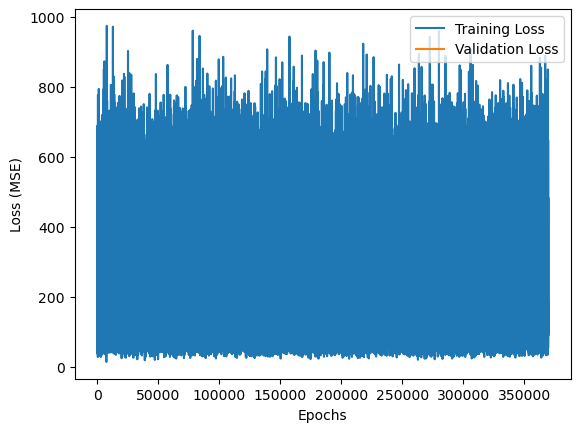

In [ ]:


# Visualization
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [ ]:

# Save the model
torch.save(model.state_dict(), 'model.pth')


In [ ]:

# evaluate the model
# model.eval()
# with torch.no_grad():
#     y_pred = model(X)
#     loss = loss_fn(y_pred, y.view(-1, 1))
#     print(f'Loss: {loss.item():.4f}')
    
#     # Print the first 5 predictions
#     y_pred = y_pred.cpu()
#     y = y.cpu()
#     print(y_pred[:5].numpy().flatten())
#     print(y[:5].numpy())